In [19]:
import numpy as np
from scipy.stats import pearsonr
from sklearn.linear_model import Ridge

x = np.random.normal(0, 1, (100, 3))
y_a = 2*x[:, 0] + x[:, 1] + np.random.normal(0, 1, 100)
y_b = 3*x[:, 1] - 2*x[:,2] + np.random.normal(0, 1, 100)

y = np.transpose([y_a, y_b])

rgr = Ridge(alpha=10).fit(x, y_a)

In [20]:
rgr.coef_

array([2.066651  , 0.73945648, 0.07347101])

In [21]:
rgr.intercept_

-0.0537119617944642

In [22]:
rgr.score(x, y_a)

0.8800153291531281

In [23]:
y_hat = rgr.predict(x)

In [30]:
1 - np.nanmean((y_hat - y_a)**2)/np.nanvar(y_a, ddof=0)

0.8800153291531281

In [27]:
pearsonr(y_hat, y_a)[0]**2

0.8856101034356889

# Analyze the sensitivity of different neural responses to perturbations to different parts of song

In [1]:
%matplotlib inline
import editdistance
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.decomposition import PCA
from scipy import signal
from scipy.ndimage import gaussian_filter1d as smooth

from aux import zscore, get_seg
from disp import set_plot, plot_b, get_line

cc = np.concatenate

FPS_DN = 8.5  # sampling rate from neural data
DT_DN = 1/FPS_DN
NT_H_DN = 85
T_H_DN = np.arange(NT_H_DN)*DT_DN

FPS = 30.03  # sampling rate of behavioral data
DT = 1/FPS
NT_H = int(round(NT_H_DN*FPS/FPS_DN))
T_H = np.arange(NT_H)*DT

NR = 224  # original number of responses
NTR = 276  # number of trials

In [2]:
DF_DYN_PARAM = pd.read_csv('data/simple/neur/baker_masoff_fit_param.csv')

tau_rs = np.array(DF_DYN_PARAM['TAU_R'])
tau_as = np.array(DF_DYN_PARAM['TAU_A'])
x_s_all = np.array(DF_DYN_PARAM['X_S'])
x_p_all = np.array(DF_DYN_PARAM['X_P'])
x_qs_all = np.array(DF_DYN_PARAM['X_QS'])
x_ps_all = np.array(DF_DYN_PARAM['X_PS'])


DF_DYN_PARAM

,EXPT_ID,LINE,FLY,ROI,ROI_USED,FIT_ERR,SUCCESS,T_0,R_0,TAU_R,TAU_A,X_S,X_P,X_QS,X_PS
0,0,R70G01,0,somas,False,0.275200,True,-0.000000,0.028883,6.202560,30.338151,-4.958240,-2.597416,0.0,0.0
1,1,R70G01,1,somas,False,0.186212,True,0.117647,0.025133,3.835537,21.818473,-4.164089,-1.472157,0.0,0.0
2,2,R70G01,2,somas,False,0.248414,True,-0.000000,0.055965,6.017155,15.057796,-6.248048,-2.095966,0.0,0.0
3,3,R70G01,3,somas,False,0.455963,True,-0.000000,-0.014222,6.016732,11.820065,-5.679817,-2.118260,0.0,0.0
4,4,R70G01,4,somas,False,0.229018,True,-0.000000,0.019839,6.434871,55.490979,-4.415793,-2.863646,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,219,VT34811,0,somas,False,0.276088,True,-0.000000,0.039049,1.801211,1186.088483,-0.049827,2.496913,0.0,0.0
220,220,VT34811,0,ascending projection,False,0.037801,True,-0.000000,-0.001886,1.298842,27.643238,0.098451,2.457383,0.0,0.0
221,221,vPN1_split,0,somas,False,0.404112,True,-0.588235,-0.014702,4.151231,6.155540,8.332275,2.353221,0.0,0.0
222,222,vPN1_split,1,somas,False,1.205977,True,0.235294,-0.095622,5.922635,90.755820,2.390309,0.604363,0.0,0.0


In [3]:
sorted(tau_as[tau_as <= 1])

[0.2722196236431237,
 0.3762885679475609,
 0.3782186527406551,
 0.4872066572797658,
 0.545946000379398,
 0.5554398273170209,
 0.574547269660932,
 0.5914231970750808,
 0.6419975710332025,
 0.6429369516442064,
 0.715776043942086,
 1.0]

In [4]:
from aux import get_sine_off_cur

# define smln & obj function
def smlt(i_s, i_p, tau_r, tau_a, x_s, x_p, x_qs, x_ps):
    """Simulate response to song inputs."""
    
    i_s, i_p, i_qs, i_ps = get_sine_off_cur(i_s, i_p)[:4]
    
    t = np.arange(len(i_s))*DT
    r = np.nan*np.zeros(len(t))
    
    r[0] = 0
    a_s, a_p, a_qs, a_ps = 0, 0, 0, 0
    
    for ct, t_ in enumerate(t[1:], 1):
        a_s += ((DT/tau_a) * (-a_s + i_s[ct]))
        a_p += ((DT/tau_a) * (-a_p + i_p[ct]))
        a_qs += ((DT/tau_a) * (-a_qs + i_qs[ct]))
        a_ps += ((DT/tau_a) * (-a_ps + i_ps[ct]))
        r[ct] = r[ct-1] + (DT/tau_r) * (-r[ct-1] + (1 - a_s)*x_s*i_s[ct] + (1 - a_p)*x_p*i_p[ct] + (1 - a_qs)*x_qs*i_qs[ct] + (1 - a_ps)*x_ps*i_ps[ct])
    
    return r

In [5]:
# step sine and step pulse
t_step = np.arange(0, 20, DT)
i_step = (t_step < 10).astype(float)
i_0 = np.zeros(len(t_step))

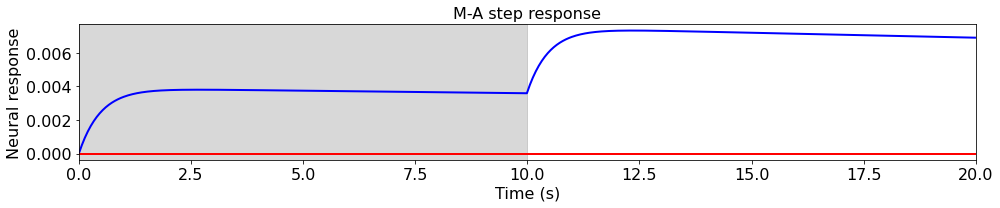

In [6]:
tau_r = 120
tau_a = .5
x_s = 1
x_p = 0
x_qs = 1
x_ps = 0

fig, ax = plt.subplots(1, 1, figsize=(14, 3), tight_layout=True)
ax.plot(t_step, smlt(i_step, i_0, tau_r, tau_a, x_s, x_p, x_qs, x_ps), c='b', lw=2)
ax.plot(t_step, smlt(i_0, i_step, tau_r, tau_a, x_s, x_p, x_qs, x_ps), c='r', lw=2)

set_plot(ax, x_lim=(0, 20), x_label='Time (s)', y_label='Neural response', title='M-A step response', font_size=16)
ax.axvspan(0, 10, color='gray', alpha=.3)

In [7]:
# song snippets
def make_sng(t_max, s=None, p=None):
    if s is None:
        s = []
    if p is None:
        p = []
        
    t = np.arange(0, t_max, DT)
    sng = np.zeros(len(t))
    
    for start, end in s:
        sng[(start <= t) & (t < end)] = 1
        
    for start, end in p:
        sng[(start <= t) & (t < end)] = 2
    
    return sng.astype(int)

# Natural song snippets

In [8]:
STRAINS = ['NM91', 'ZH23']
FSTRAIN = 'data/simple/strains.csv'

MSTRAINS = [(pd.read_csv(FSTRAIN)['STRAIN'] == strain) for strain in STRAINS]
MSTRAIN = np.any(MSTRAINS, axis=0)
ISTRAIN = MSTRAIN.nonzero()[0]

NTR = MSTRAIN.sum()

In [9]:
# load natural songs
df_song = pd.read_csv('data/simple/c_song_f_behav.csv')[['ID', 'T', 'Q', 'S', 'P' ,'F']]
sngs_full = []
for itr in ISTRAIN:
    df_tr = df_song[df_song['ID'] == itr]
    sng_full = np.zeros(len(df_tr), dtype=int)
    sng_full[df_tr['S'] == 1] = 1
    sng_full[(df_tr['P'] == 1) | (df_tr['F'] == 1)] = 2
    sngs_full.append(sng_full)

In [10]:
from aux import get_seg
# get snippets
nt = int(round(20*FPS))
t = np.arange(nt)*DT

min_gap = int(round(5*FPS))
min_frac_sing = 0

sng_s = np.zeros(len(t))
sng_s[t < 10] = 1
sng_p = np.zeros(len(t))
sng_p[t < 10] = 2

sngs_all = [sng_s, sng_p]  # song snippets


for ctr, sng_full in enumerate(sngs_full):
    segs, bds = get_seg(sng_full > 0, min_gap=min_gap)
    segs = [sng_full[lb:ub] for lb, ub in bds]
    # keep fixed-length portions only of sufficiently long segments
    segs = [seg[:nt] for seg in segs if (len(seg) >= nt) and (np.mean(seg > 0) > min_frac_sing)]
    sngs_all.extend(segs)
    
sngs_all = np.array(sngs_all)[:400]

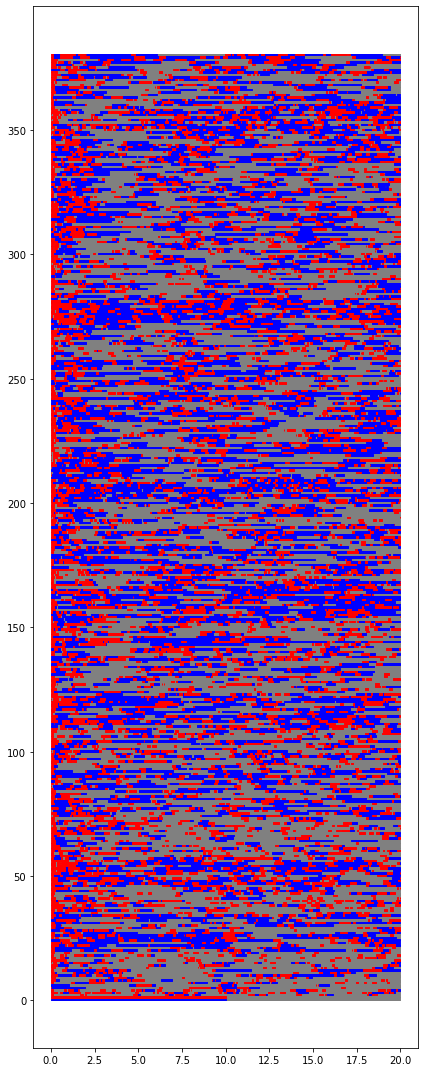

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(6, 15), tight_layout=True)
for csng, sng in enumerate(sngs_all):
    plot_b(ax, t, sng, [0, t.max(), csng, csng+.7], c=['gray', 'b', 'r'])

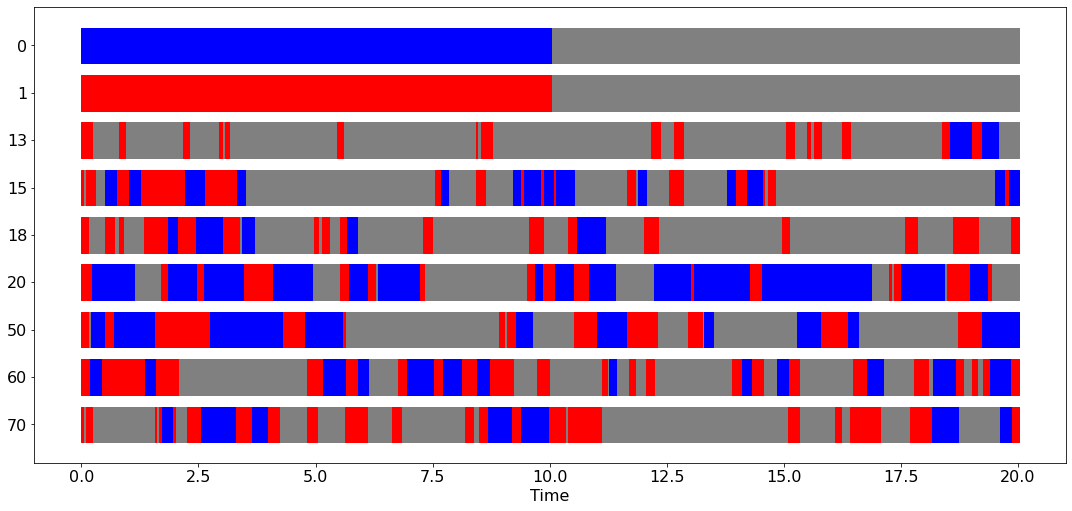

In [12]:
# pick a nice example song
isngs = [0, 1, 13, 15, 18, 20, 50, 60, 70]
sngs = [sngs_all[isng] for isng in isngs]

fig, ax = plt.subplots(1, 1, figsize=(15, .8*len(isngs)), tight_layout=True)
y_ticks = -np.arange(len(isngs))-.375
for csng, sng in enumerate(sngs):
    plot_b(ax, t, sng, [0, t[-1]+DT, -csng, -csng-.75], c=['gray', 'b', 'r'])
set_plot(ax, x_label='Time', y_ticks=y_ticks, y_tick_labels=isngs, font_size=16)

## MASRB model

$$\tau_r \frac{dr}{dt} = -r + (1-a_s)x_sI_s(t) + (1-a_p)x_pI_p(t) + a_sx_{q/s}I_{q/s} + a_sx_{p/s}I_{p/s}$$

$$\tau_a \frac{da_s}{dt} = -a_s + I_s(t) \quad\quad\quad \tau_a \frac{da_p}{dt} = -a_p + I_p(t)$$

In [19]:
from aux import get_sine_off_cur

# define smln & obj function
def smlt(i_s, i_p, tau_r, tau_a, x_s, x_p, x_qs, x_ps):
    """Simulate response to song inputs."""
    
    i_s, i_p, i_qs, i_ps = get_sine_off_cur(i_s, i_p)[:4]
    
    t = np.arange(len(i_s))*DT
    r = np.nan*np.zeros(len(t))
    
    r[0] = 0
    a_s, a_p = 0, 0
    
    for ct, t_ in enumerate(t[1:], 1):
        a_s += ((DT/tau_a) * (-a_s + i_s[ct]))
        a_p += ((DT/tau_a) * (-a_p + i_p[ct]))
        r[ct] = r[ct-1] + (DT/tau_r) * (-r[ct-1] + (1 - a_s)*x_s*i_s[ct] + (1 - a_p)*x_p*i_p[ct] + a_s*x_qs*i_qs[ct] + a_s*x_ps*i_ps[ct])
    
    return r

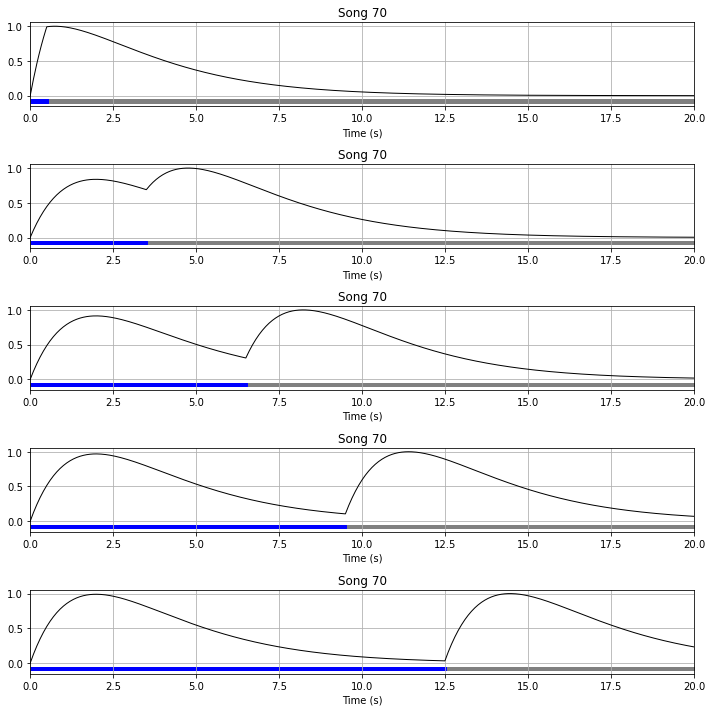

In [29]:
nsng = 5
fig, axs = plt.subplots(nsng, 1, figsize=(10, nsng*2), tight_layout=True)

for csng, ax in enumerate(axs):

    sng = np.zeros(len(t))
    sng[t < 3*csng+.5] = 1
    
    i_s = (sng == 1).astype(float)
    i_p = (sng == 2).astype(float)
    
    r = smlt(i_s, i_p, tau_r=2, tau_a=2, x_s=1, x_p=0, x_qs=1, x_ps=0)
    ax.plot(t, r/r.max(), lw=1, c='k')
        
    plot_b(ax, t, sng, [0, t[-1]+DT, -.1, -.05], c=['gray', 'b', 'r'])
    set_plot(ax, x_lim=(0, 20), x_label='Time (s)', title=f'Song {isng}')
    ax.grid()